In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt



In [2]:
df = pd.read_excel(r"D:\Final_Project\LSTM\final_synthetic_lstm.xlsx")

In [3]:
df

,patient_id,hour,heart_rate,systolic_bp,diastolic_bp,spo2,respiratory_rate,temperature
0,0,0,83.2,115.3,84.2,99.1,12.1,36.8
1,0,1,88.0,110.3,84.8,99.2,15.9,36.5
2,0,2,84.2,120.9,96.7,100.2,17.5,36.7
3,0,3,84.8,122.7,87.6,99.1,15.3,36.7
4,0,4,85.6,117.9,85.6,100.0,14.8,36.8
...,...,...,...,...,...,...,...,...
29995,1199,20,82.8,100.1,75.2,96.4,16.5,36.8
29996,1199,21,83.1,111.6,89.5,95.7,20.0,36.6
29997,1199,22,82.9,108.4,81.2,94.8,22.1,36.7
29998,1199,23,78.6,106.6,84.2,94.1,23.2,36.9


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   patient_id        30000 non-null  int64  
 1   hour              30000 non-null  int64  
 2   heart_rate        30000 non-null  float64
 3   systolic_bp       30000 non-null  float64
 4   diastolic_bp      30000 non-null  float64
 5   spo2              30000 non-null  float64
 6   respiratory_rate  30000 non-null  float64
 7   temperature       30000 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 1.8 MB


In [5]:
df.describe()

,patient_id,hour,heart_rate,systolic_bp,diastolic_bp,spo2,respiratory_rate,temperature
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,599.500000,12.000000,81.196913,119.764600,80.152243,96.758317,18.042610,36.808367
std,346.415815,7.211223,10.782407,15.687614,10.684273,2.293260,3.681098,0.409006
min,0.000000,0.000000,40.300000,59.700000,43.300000,87.600000,3.400000,35.300000
25%,299.750000,6.000000,73.900000,109.400000,72.600000,95.200000,15.600000,36.500000
50%,599.500000,12.000000,81.200000,119.700000,80.000000,96.800000,18.000000,36.800000
75%,899.250000,18.000000,88.500000,130.300000,87.600000,98.300000,20.600000,37.100000
max,1199.000000,24.000000,122.400000,176.300000,120.500000,105.500000,32.000000,38.300000


In [6]:
df['patient_id'].nunique()


1200

In [7]:
df.groupby('patient_id')['hour'].nunique().describe()


count    1200.0
mean       25.0
std         0.0
min        25.0
25%        25.0
50%        25.0
75%        25.0
max        25.0
Name: hour, dtype: float64

In [8]:
df.isnull().sum()


patient_id          0
hour                0
heart_rate          0
systolic_bp         0
diastolic_bp        0
spo2                0
respiratory_rate    0
temperature         0
dtype: int64

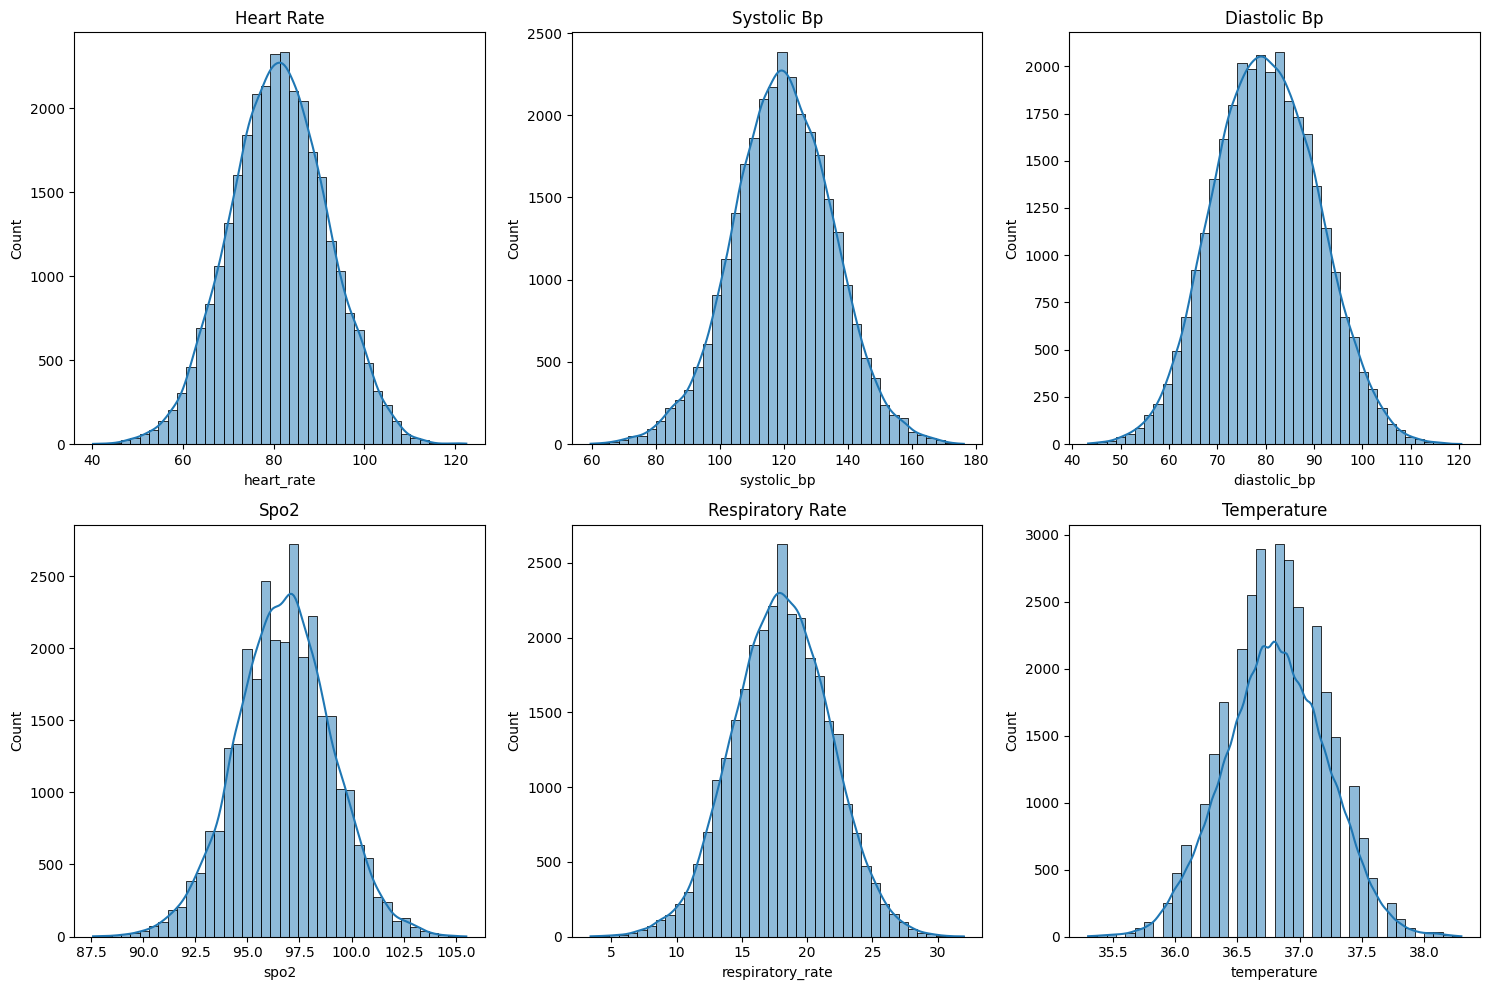

In [9]:
import seaborn as sns
vitals = [
    "heart_rate",
    "systolic_bp",
    "diastolic_bp",
    "spo2",
    "respiratory_rate",
    "temperature"
]

plt.figure(figsize=(15, 10))
for i, col in enumerate(vitals, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], bins=40, kde=True)
    plt.title(col.replace("_", " ").title())

plt.tight_layout()
plt.show()


📌 Interpretation:

HR: right-skew → tachycardia cases

SpO₂: left tail → hypoxia

RR: wider spread → respiratory distress

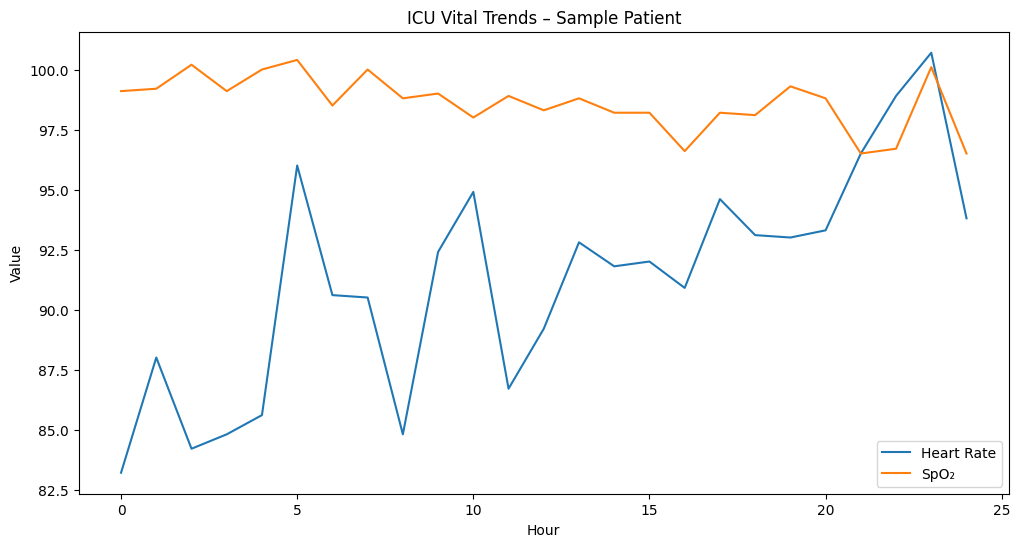

In [10]:
sample_patient = df['patient_id'].iloc[0]

patient_df = df[df['patient_id'] == sample_patient]

plt.figure(figsize=(12, 6))
plt.plot(patient_df['hour'], patient_df['heart_rate'], label="Heart Rate")
plt.plot(patient_df['hour'], patient_df['spo2'], label="SpO₂")
plt.xlabel("Hour")
plt.ylabel("Value")
plt.title("ICU Vital Trends – Sample Patient")
plt.legend()
plt.show()


“Vitals show temporal dependency, justifying recurrent neural networks.”

In [11]:
import tensorflow as tf
print(tf.__version__)

2.13.0


# Correlation Analysis

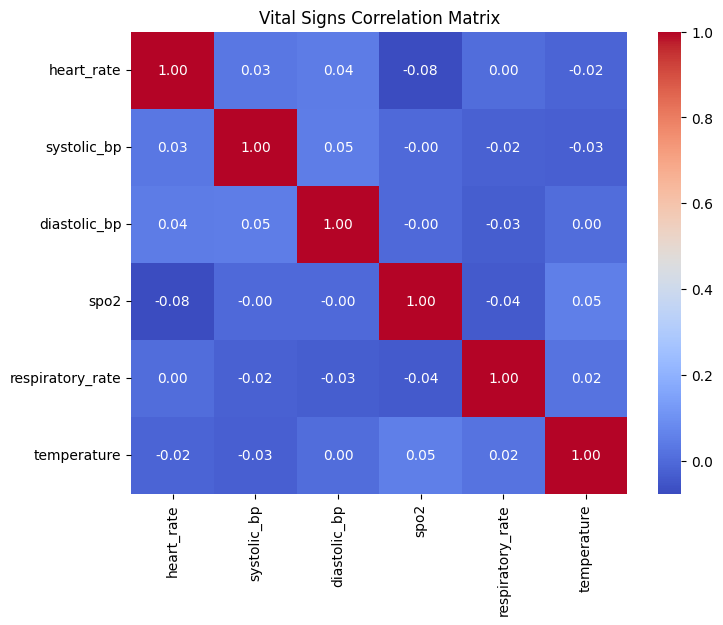

In [12]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    df[vitals].corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Vital Signs Correlation Matrix")
plt.show()


📌 Expected Findings:

    HR ↑ ↔ RR ↑

    SpO₂ ↓ ↔ HR ↑

    BP moderately independent

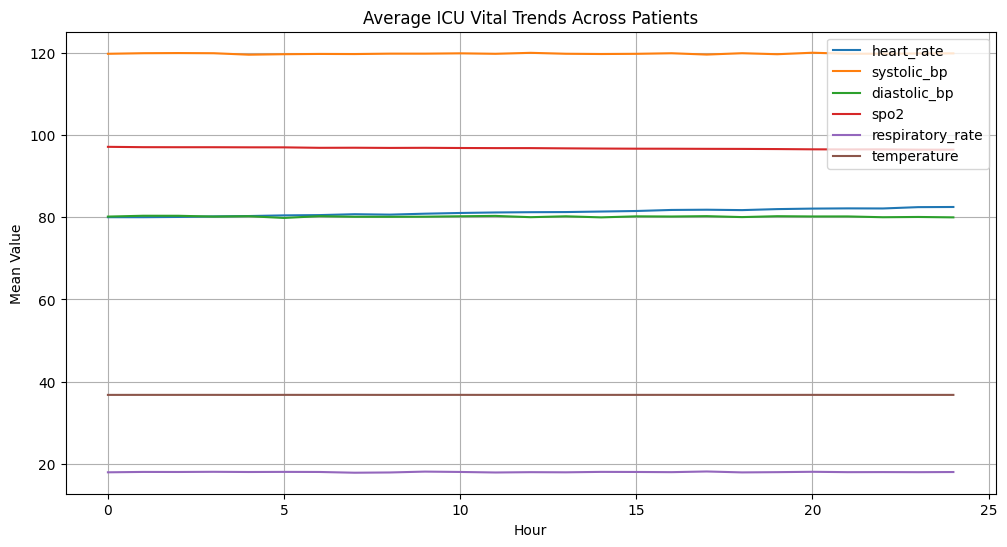

In [13]:
#Population-Level Temporal Patterns
mean_trends = df.groupby('hour')[vitals].mean()

mean_trends.plot(figsize=(12, 6))
plt.title("Average ICU Vital Trends Across Patients")
plt.xlabel("Hour")
plt.ylabel("Mean Value")
plt.grid()
plt.show()


“Aggregated trends reveal subtle deterioration patterns across time.”

In [14]:
FEATURES = [
    "heart_rate",
    "systolic_bp",
    "diastolic_bp",
    "spo2",
    "respiratory_rate",
    "temperature"
]


In [15]:
scaler = MinMaxScaler()
df[FEATURES] = scaler.fit_transform(df[FEATURES])


In [16]:
X, y = [], []

In [17]:
for pid in df.patient_id.unique():
    patient_df = df[df.patient_id == pid].sort_values("hour")
    
    X.append(patient_df[FEATURES].iloc[:24].values)   # past 24 hrs
    y.append(patient_df["heart_rate"].iloc[24])       # next hour HR

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)  # (patients, 24, 6)
print("y shape:", y.shape)

X shape: (1200, 24, 6)
y shape: (1200,)


# LSTM Model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [19]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(24, 6)),
    Dropout(0.3),
    LSTM(64),
    Dense(32, activation="relu"),
    Dense(1)   # Next-hour heart rate
])

model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 128)           69120     
                                                                 
 dropout (Dropout)           (None, 24, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 120641 (471.25 KB)
Trainable params: 120641 (471.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
model.fit(
    X, y,
    epochs=30,
    batch_size=64,
    validation_split=0.2
)


Epoch 1/30
15/15 [==============================] - 6s 177ms/step - loss: 0.0395 - mae: 0.1523 - val_loss: 0.0130 - val_mae: 0.0923
Epoch 2/30
15/15 [==============================] - 1s 38ms/step - loss: 0.0134 - mae: 0.0935 - val_loss: 0.0076 - val_mae: 0.0711
Epoch 3/30
15/15 [==============================] - 1s 68ms/step - loss: 0.0068 - mae: 0.0663 - val_loss: 0.0031 - val_mae: 0.0458
Epoch 4/30
15/15 [==============================] - 1s 98ms/step - loss: 0.0030 - mae: 0.0434 - val_loss: 0.0019 - val_mae: 0.0349
Epoch 5/30
15/15 [==============================] - 1s 96ms/step - loss: 0.0027 - mae: 0.0415 - val_loss: 0.0017 - val_mae: 0.0331
Epoch 6/30
15/15 [==============================] - 1s 99ms/step - loss: 0.0023 - mae: 0.0377 - val_loss: 0.0016 - val_mae: 0.0315
Epoch 7/30
15/15 [==============================] - 2s 103ms/step - loss: 0.0023 - mae: 0.0387 - val_loss: 0.0019 - val_mae: 0.0354
Epoch 8/30
15/15 [==============================] - 2s 108ms/step - loss: 0.0024 

In [21]:
import joblib
model.save("icu_lstm_hr_model.h5")



c:\Users\ashwi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
joblib.dump(scaler, "lstm_feature_scaler.pkl")

['lstm_feature_scaler.pkl']

# ICU Deterioration Logic

In [22]:
def icu_risk_level(pred_hr, spo2):
    """
    Simple clinical rule-based risk mapping
    """
    if pred_hr > 130 or spo2 < 90:
        return "🔴 Critical"
    elif pred_hr > 100 or spo2 < 94:
        return "🟠 Warning"
    else:
        return "🟢 Stable"


In [23]:
sample_cases = [
    (85, 97),
    (105, 93),
    (130, 88)
]

for hr, spo2 in sample_cases:
    print(f"HR={hr}, SpO2={spo2} → Risk={icu_risk_level(hr, spo2)}")

HR=85, SpO2=97 → Risk=🟢 Stable
HR=105, SpO2=93 → Risk=🟠 Warning
HR=130, SpO2=88 → Risk=🔴 Critical
